In [6]:
import os
import json
import random

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from rich import print as pprint
from visual_graph_datasets.util import dynamic_import
from visual_graph_datasets.data import VisualGraphDatasetReader

from truthful_counterfactuals.utils import EXPERIMENTS_PATH

In [7]:
PATH = os.getcwd()

PROCESSING_PATH = os.path.join(EXPERIMENTS_PATH, 'assets', 'process.py')
VISUAL_GRAPH_DATASET = os.path.join(EXPERIMENTS_PATH, 'assets', 'logp')

In [8]:
print('loading processing...')
module = dynamic_import(PROCESSING_PATH)
processing = module.processing
print(f'processing: {processing}')

print('loading dataset...')
reader = VisualGraphDatasetReader(VISUAL_GRAPH_DATASET)
index_data_map = reader.read()
indices = list(index_data_map.keys())
graphs = [data['metadata']['graph'] for data in index_data_map.values()]
print(f'loaded dataset with {len(index_data_map)} samples')

loading processing...
processing: <VgdMoleculeProcessing None>
loading dataset...
loaded dataset with 11024 samples


determine value-OOD set...
percentiles:
 * 5: -2.5032799999999993
 * 95: 6.6206000000000005


/tmp/ipykernel_2295503/2380668381.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  values = [float(graph['graph_labels']) for graph in graphs]


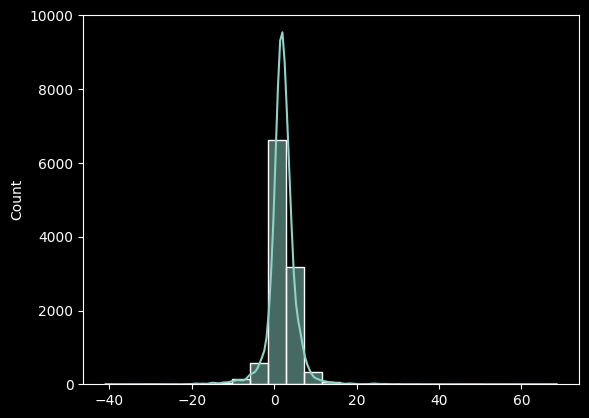

In [9]:
print('determine value-OOD set...')

values = [float(graph['graph_labels']) for graph in graphs]
sns.histplot(values, bins=25, kde=True)
print(f'percentiles:')
print(f' * 5: {np.percentile(values, 5)}')
print(f' * 95: {np.percentile(values, 95)}')

In [10]:
VALUE_MIN = -2
VALUE_MAX = 6

indices_ood_value = [i for i, value in zip(indices, values) if value < VALUE_MIN or value > VALUE_MAX]
print(f'selected {len(indices_ood_value)} samples')

path_ood_value = os.path.join(PATH, 'ood_value.json')
with open(path_ood_value, 'w') as file:
    content = json.dumps(indices_ood_value)
    file.write(content)

selected 1399 samples


In [11]:
print('determine structure-OOD set...')

atom_index_map = {
    'S': [],
    'O': [],
    'N': [],
    'Cl': [],
    'F': [],
}

for index, graph in zip(indices, graphs):
    smiles = str(graph['graph_repr'])
    
    for atom in atom_index_map.keys():
        if atom in smiles:
            atom_index_map[atom].append(index)
            
atom_length_map = {key: len(values) for key, values in atom_index_map.items()}
pprint(atom_length_map)

indices_ood_struct = atom_index_map['Cl']
print(f'selected {len(indices_ood_struct)} samples')

path_ood_struct = os.path.join(PATH, 'ood_struct.json')
with open(path_ood_struct, 'w') as file:
    content = json.dumps(indices_ood_struct)
    file.write(content)

determine structure-OOD set...


{'S': 1914, 'O': 8897, 'N': 5452, 'Cl': 1960, 'F': 546}

selected 1960 samples


In [12]:
import rdkit.Chem as Chem

struct_index_map = {
    # hydroxyl
    '[OX2H]': [],
    # carboxyl
    '[C](=O)[O]': [],
    # amino group
    '[N][H][H]': [],
    # nitro group
    '[N+](=O)[O-]': [],
}

for index, graph in zip(indices, graphs):
    smiles = str(graph['graph_repr'])
    
    for struct in struct_index_map.keys():
        smarts = Chem.MolFromSmarts(struct)
        mol = Chem.MolFromSmiles(smiles)
        if mol.HasSubstructMatch(smarts):
            struct_index_map[struct].append(index)
            

struct_length_map = {key: len(values) for key, values in struct_index_map.items()}
pprint(struct_length_map)

{'[OX2H]': 3626, '[C](=O)[O]': 3307, '[N][H][H]': 0, '[N+](=O)[O-]': 604}

In [13]:
import deepchem as dc
from deepchem.splits import ScaffoldSplitter
from deepchem.data import NumpyDataset

In [30]:
smiles_list = [str(graph['graph_repr']) for graph in graphs]
Xs = np.array(indices)
Ys = np.ones(len(smiles_list))
dataset = dc.data.DiskDataset.from_numpy(X=Xs,y=Ys,w=np.zeros(len(smiles_list)),ids=smiles_list)

splitter = ScaffoldSplitter()
train_dataset, test_dataset = splitter.train_test_split(dataset=dataset, frac_train=0.9)
train_smiles = train_dataset.ids
test_smiles = test_dataset.ids

print("Training SMILES:", len(train_smiles), train_smiles, train_dataset.X)
print("Test SMILES:", len(test_smiles), test_smiles, test_dataset.X)

indices_ood_struct = test_dataset.X.astype(int).tolist()
path_ood_struct = os.path.join(PATH, 'ood_struct.json')
with open(path_ood_struct, 'w') as file:
    content = json.dumps(indices_ood_struct)
    file.write(content)

Training SMILES: 9921 ['CCCCCCCCCCC(C)CCCCCCCC' 'NC(=O)N=NC(N)=O' '[C-]#[O+]' ...
 'CC1=C(OCC2=CC=CC=C2)C=CC2=C1OC(N1CCOCC1)=CC2=O'
 'NC(=O)C1=CN=C2N1CCC1=C(C=CC=C1)C21CCNCC1'
 'c1ccc2Sc3ccccc3N(CC4CN(C)CCC4)c2c1'] [   3    4    8 ... 9983 9977 9961]
Test SMILES: 1103 ['C1CCC(CC1)[Sn](C2CCCCC2)C3CCCCC3.O' 'c1ccc2C(=O)N=C(c3ccccc3)Oc2c1'
 'c1ccc2C(O)N3CCC(O)C3=Nc2c1' ...
 '[Zn++].Cc1cccc2[N-]C(=S)Nc12.Cc3cccc4NC(=S)[N-]c34'
 'C1OC1COc2ccc3c(OCC4CO4)cccc3c2' 'O=C1CCCCCCCCCOCCCCCO1'] [9956 9897 9842 ...   24   18    2]
